# 1. Imports

In [1]:
from utils.data_preparation import *
from utils.preprocessing import *
from models.model import *
from utils.optimizers import *
from utils.tools import *
from models.mcunet.mcunet.model_zoo import net_id_list, build_model, download_tflite

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from tqdm import tqdm
import matplotlib.pyplot as plt
import copy


import torch
from torch.profiler import profile, record_function, ProfilerActivity
from time import time
from codecarbon import EmissionsTracker

# 2. Data

In [2]:
path = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/data/4_BMIS_EMG_VLM/EX5/mat_data'
subject_number = 1

# path = '/mnt/d/AI-Workspace/sEMGClassification/BMIS_EMG_DATA/data/mat_data'
# subject_number = 30

number_gestures = 7
fs = 200

# record_time = 5
# train_repetition = [1]
# test_repetition = [2]

record_time = 5
train_repetition = [1, 3, 4, 6]
test_repetition = [2, 5]

gesture = [1, 2, 3, 4, 5, 6, 7]
selected_gesture = [1, 2, 3, 4, 5, 6, 7]
num_gesture = len(gesture)
batch_size = 32

no_channel = 7
low_cut = 10.0
high_cut = 99.0
notch_freq = 60.0
window_time = 200
overlap = 60

In [3]:
# Data Preparation
emg_prep = EMGDataPreparation(base_path=path, fs=fs, rec_time=record_time)
subject_path, train_gesture, test_gesture = emg_prep.get_per_subject_file(subject_number=subject_number, num_gesture=num_gesture, train_repetition=train_repetition, test_repetition=test_repetition)
train_data, test_data = emg_prep.load_data_per_subject(subject_path, selected_gesture=selected_gesture, train_gesture=train_gesture, test_gesture=test_gesture)
train_data, train_labels = emg_prep.get_data_labels(train_data)
test_data, test_labels = emg_prep.get_data_labels(test_data)

# Preprocessing
preprocess = EMGPreprocessing(fs=fs, notch_freq=notch_freq, low_cut=low_cut, high_cut=high_cut, order=5)
train_data = preprocess.remove_mains(train_data)
test_data = preprocess.remove_mains(test_data)
train_data = preprocess.bandpass_filter(train_data)
test_data = preprocess.bandpass_filter(test_data)

# Overlap Windowing
window_train_data, window_train_labels = emg_prep.window_with_overlap(train_data, train_labels, window_time=window_time, overlap=overlap, no_channel=no_channel)
window_test_data, window_test_labels = emg_prep.window_with_overlap(test_data, test_labels, window_time=window_time, overlap=overlap, no_channel=no_channel)

# Expand Dimension
window_train_data = np.expand_dims(window_train_data, axis=1)
window_test_data = np.expand_dims(window_test_data, axis=1)

# Apply balancing to train and test sets
window_train_data, window_train_labels = balance_classes(window_train_data, window_train_labels)
window_test_data, window_test_labels = balance_classes(window_test_data, window_test_labels)

# Shuffle the balanced datasets
window_train_data, window_train_labels = shuffle_data(window_train_data, window_train_labels)
window_test_data, window_test_labels = shuffle_data(window_test_data, window_test_labels)

# # Convert to Tensor
train_dataset = EMGDataset(window_train_data, window_train_labels)
test_dataset = EMGDataset(window_test_data, window_test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


window_train_data.shape, window_train_labels.shape, window_test_data.shape, window_test_labels.shape

((1743, 1, 7, 40), (1743,), (868, 1, 7, 40), (868,))

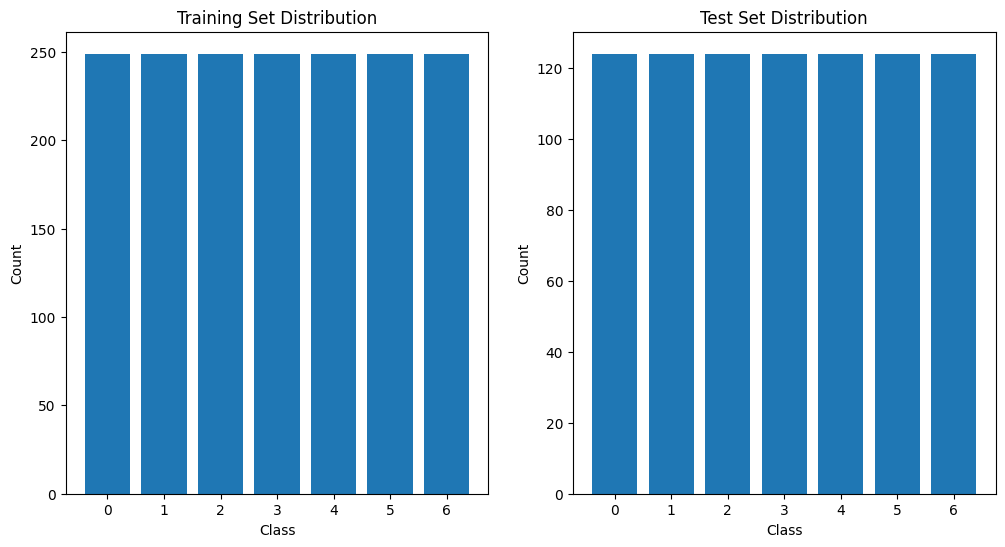

In [4]:
np.unique(window_train_labels, return_counts=True), np.unique(window_test_labels, return_counts=True)
counts_train = np.unique(window_train_labels, return_counts=True)
counts_test = np.unique(window_test_labels, return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(counts_train[0], counts_train[1])
ax[0].set_title('Training Set Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

ax[1].bar(counts_test[0], counts_test[1])
ax[1].set_title('Test Set Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.show()

# 3. Architecture

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model = EMGFANNew(1, number_gestures, similarparameter=False)
meta_model.to(device)

EMGFANNew(
  (first): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FAN): FANLayer(
    (input_linear_p): Linear(in_features=576, out_features=64, bias=True)
    (input_linear_g): Linear(in_features=576, out_features=128, bias=True)
    (activation): GELU(approximate='none')
  )
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh3): ReLU()
  (last): Linear(in_features=256, out_features=7, bias=True)
)

In [6]:
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/MetaLearn/emgfan_7_c.pth'
meta_model.load_state_dict(torch.load(save_dir_meta))

<All keys matched successfully>

# 4. Few Shot

## 4.1. None 

In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
def test_loop(model, train_device, data, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data:
            X = X.float().to(train_device)
            y = y.long().to(train_device)
            model = model.to(train_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            total += y.size(0)
            correct += (y_pred.argmax(1) == y).sum().item()

    return test_loss / total, correct / total

In [9]:
print(f"FAN Fewshot Model with No Fine Tuning")
test_loss, test_acc = test_loop(meta_model, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

FAN Fewshot Model with No Fine Tuning
Test accuracy 27.9954%


## 4.2. Full Layer Fine-Tune

In [10]:
# Refresh the model
meta_model_full = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/MetaLearn/emgfan_7_c.pth'
meta_model_full.load_state_dict(torch.load(save_dir_meta))
meta_model_full.to(device)

EMGFANNew(
  (first): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FAN): FANLayer(
    (input_linear_p): Linear(in_features=576, out_features=64, bias=True)
    (input_linear_g): Linear(in_features=576, out_features=128, bias=True)
    (activation): GELU(approximate='none')
  )
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh3): ReLU()
  (last): Linear(in_features=256, out_features=7, bias=True)
)

In [11]:
epochs = 10
learning_rate = 0.001
optimizer = optim.Adam(meta_model_full.parameters(), lr=learning_rate)

In [12]:
def fine_tune_loop(model, train_device, data, loss_fn, optimizer):

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    # print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")
    # print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e6} MB")

    # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')) as prof:
    #     with record_function("model_training"):

    for X, y in data:


            optimizer.zero_grad()

            X = X.float().to(train_device)
            y = y.long().to(train_device)
            model = model.to(train_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            #scheduler.step()

            train_loss += loss.item()
            total += y.size(0)
            correct += (y_pred.argmax(1) == y).sum().item()

    # print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")
    # print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e6} MB")
    # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

    return train_loss / total, correct / total

In [13]:
print(f"FineTune on {device}")
train_accuracy_per_epoch = []


# tracker = EmissionsTracker()
# tracker.start()
start_time = time()

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(meta_model_full, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

end_time = time()
# tracker.stop()


AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"Fewshot Model Test On Full Layer FineTune")
test_loss, test_acc = test_loop(meta_model_full, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]

Epoch 10/10
The Average FineTune Accuracy: 91.9851%
The Last FineTune Accuracy 97.6477%
Fewshot Model Test On Full Layer FineTune
Test accuracy 92.1659%
Training Time is 1.6723687648773193


## 4.3 Last Layer Fine Tune

In [14]:
# Refresh the model
meta_model_last = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/MetaLearn/emgfan_7_c.pth'
meta_model_last.load_state_dict(torch.load(save_dir_meta))
meta_model_last.to(device)
optimizer = optim.Adam(meta_model_last.parameters(), lr=learning_rate)

for param in meta_model_last.parameters():
    param.requires_grad = False
for param in meta_model_last.last.parameters():
    param.requires_grad = True

def is_layer_frozen(layer):
    return all(not param.requires_grad for param in layer.parameters())
print("fc1 is frozen:", is_layer_frozen(meta_model_last.last))


print(f"FineTune on {device}")
train_accuracy_per_epoch = []


# tracker = EmissionsTracker()
# tracker.start()
start_time = time()

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(meta_model_last, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

end_time = time()
# tracker.stop()
AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"Fewshot Model Test with Last Layer FineTune")
test_loss, test_acc = test_loop(meta_model_last, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

fc1 is frozen: False
FineTune on cuda


100%|██████████| 10/10 [00:00<00:00, 12.05it/s]

Epoch 10/10
The Average FineTune Accuracy: 83.6890%
The Last FineTune Accuracy 91.6810%
Fewshot Model Test with Last Layer FineTune
Test accuracy 89.8618%
Training Time is 0.8313536643981934


## 4.4. TinyTL

In [15]:
meta_model_tinytl = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/MetaLearn/emgfan_7_c.pth'
meta_model_tinytl.load_state_dict(torch.load(save_dir_meta))
meta_model_tinytl.to(device)
optimizer = optim.Adam(meta_model_tinytl.parameters(), lr=learning_rate)


for name, param in meta_model_tinytl.named_parameters():
    
    if 'weight' in name:
        param.requires_grad = False # Freeze the weights
    elif 'bias' in name:
        param.requires_grad = True # Unfreeze the bias

print(f"FineTune on {device}")
train_accuracy_per_epoch = []


# tracker = EmissionsTracker()
# tracker.start()
start_time = time()
for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(meta_model_tinytl, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)


end_time = time()
# tracker.stop()
AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"FewShot Model Test with TinyTL FineTune")
test_loss, test_acc = test_loop(meta_model_tinytl, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  8.21it/s]

Epoch 10/10
The Average FineTune Accuracy: 45.6741%
The Last FineTune Accuracy 57.3150%
FewShot Model Test with TinyTL FineTune
Test accuracy 66.4747%
Training Time is 1.219900369644165


## 4.5. EdgeEMGAdapt

In [16]:
meta_model_ours = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/MetaLearn/emgfan_7_c.pth'
meta_model_ours.load_state_dict(torch.load(save_dir_meta))
meta_model_ours.to(device)
optimizer = optim.Adam(meta_model_last.parameters(), lr=learning_rate)

for param in meta_model_ours.parameters():
    param.requires_grad = False
for param in meta_model_ours.last.parameters():
    param.requires_grad = True
for param in meta_model_ours.first.parameters():
    param.requires_grad = True


# def is_layer_frozen(layer):
#     return all(not param.requires_grad for param in layer.parameters())
# print("Last Layer is Forzen:", is_layer_frozen(kd_model_last.fc2))


print(f"FineTune on {device}")
train_accuracy_per_epoch = []

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(meta_model_ours, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"KD Test on Our Fine Tune {device}")
test_loss, test_acc = test_loop(meta_model_ours, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  8.84it/s]

Epoch 10/10
The Average FineTune Accuracy: 28.3764%
The Last FineTune Accuracy 28.3993%
KD Test on Our Fine Tune cuda
Test accuracy 28.4562%


# 5 PreTrain

## 5.1 None

In [17]:
pretrain_model = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/PreTrain/7_Channels/emgfan_pretrain_15.pth'
pretrain_model.load_state_dict(torch.load(save_dir_meta))
pretrain_model.to(device)

print(f"PreTrain Model Test On No FineTune")
test_loss, test_acc = test_loop(pretrain_model, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

PreTrain Model Test On No FineTune
Test accuracy 23.9631%


## 5.2. Full Layer Fine-Tune

In [18]:
pretrain_model_full = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/PreTrain/7_Channels/emgfan_pretrain_15.pth'
pretrain_model_full.load_state_dict(torch.load(save_dir_meta))
pretrain_model_full.to(device)

optimizer = optim.Adam(pretrain_model_full.parameters(), lr=learning_rate)


print(f"FineTune on {device}")
train_accuracy_per_epoch = []

# tracker = EmissionsTracker()
# tracker.start()
start_time = time()
for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(pretrain_model_full, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)


end_time = time()
# tracker.stop()

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"PreTrain Test on Full Fine Tune {device}")
test_loss, test_acc = test_loop(pretrain_model_full, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

print(f'Training Time is {end_time - start_time}')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  6.89it/s]

Epoch 10/10
The Average FineTune Accuracy: 84.6586%
The Last FineTune Accuracy 94.0906%
PreTrain Test on Full Fine Tune cuda
Test accuracy 92.6267%
Training Time is 1.4526171684265137


## 5.3. Last Layer Fine Tune

In [19]:
pretrain_model_last = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/PreTrain/7_Channels/emgfan_pretrain_15.pth'
pretrain_model_last.load_state_dict(torch.load(save_dir_meta))
pretrain_model_last.to(device)
optimizer = optim.Adam(pretrain_model_last.parameters(), lr=learning_rate)


for param in pretrain_model_last.parameters():
    param.requires_grad = False
for param in pretrain_model_last.last.parameters():
    param.requires_grad = True

def is_layer_frozen(layer):
    return all(not param.requires_grad for param in layer.parameters())
print("Last Layer is Forzen:", is_layer_frozen(pretrain_model_last.last))



print(f"FineTune on {device}")
train_accuracy_per_epoch = []

# tracker = EmissionsTracker()
# tracker.start()
start_time = time()

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(pretrain_model_last, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

# tracker.stop()
end_time = time()
AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"Test on Full Fine Tune {device}")
test_loss, test_acc = test_loop(pretrain_model_last, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

Last Layer is Forzen: False
FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  9.85it/s]

Epoch 10/10
The Average FineTune Accuracy: 63.8095%
The Last FineTune Accuracy 83.4194%
Test on Full Fine Tune cuda
Test accuracy 88.4793%
Training Time is 1.0168049335479736


## 5.4. TinyTL

In [20]:
pretrain_model_tinytl = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/PreTrain/7_Channels/emgfan_pretrain_15.pth'
pretrain_model_tinytl.load_state_dict(torch.load(save_dir_meta))
pretrain_model_tinytl.to(device)
optimizer = optim.Adam(pretrain_model_tinytl.parameters(), lr=learning_rate)



for name, param in pretrain_model_tinytl.named_parameters():
    
    if 'weight' in name:
        param.requires_grad = False # Freeze the weights
    elif 'bias' in name:
        param.requires_grad = True # Unfreeze the bias

print(f"FineTune on {device}")
train_accuracy_per_epoch = []

# tracker = EmissionsTracker()
# tracker.start()
start_time = time()
for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(pretrain_model_tinytl, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

end_time = time()
# tracker.stop()

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"Pretrain Model Test with TinyTL FineTune")
test_loss, test_acc = test_loop(pretrain_model_tinytl, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  8.09it/s]

Epoch 10/10
The Average FineTune Accuracy: 31.3081%
The Last FineTune Accuracy 38.8985%
Pretrain Model Test with TinyTL FineTune
Test accuracy 51.1521%
Training Time is 1.2368955612182617


## 5.5. EdgeEMGAdapt

In [21]:
pretrain_model_ours = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/PreTrain/7_Channels/emgfan_pretrain_15.pth'
pretrain_model_ours.load_state_dict(torch.load(save_dir_meta))
pretrain_model_ours.to(device)
optimizer = optim.Adam(pretrain_model_last.parameters(), lr=learning_rate)

for param in pretrain_model_ours.parameters():
    param.requires_grad = False
for param in pretrain_model_ours.last.parameters():
    param.requires_grad = True
for param in pretrain_model_ours.first.parameters():
    param.requires_grad = True


# def is_layer_frozen(layer):
#     return all(not param.requires_grad for param in layer.parameters())
# print("Last Layer is Forzen:", is_layer_frozen(kd_model_last.fc2))


print(f"FineTune on {device}")
train_accuracy_per_epoch = []

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(pretrain_model_ours, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"KD Test on Our Fine Tune {device}")
test_loss, test_acc = test_loop(pretrain_model_ours, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]

Epoch 10/10
The Average FineTune Accuracy: 17.7166%
The Last FineTune Accuracy 17.7281%
KD Test on Our Fine Tune cuda
Test accuracy 19.1244%


# 6 Knowledge Distillation

## 6.1. None

In [22]:
kd_model = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/KDMetaLearn/emgfankd_7_c.pth'
kd_model.load_state_dict(torch.load(save_dir_meta))
kd_model.to(device)

print(f"PreTrain Model Test On No FineTune")
test_loss, test_acc = test_loop(kd_model, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

PreTrain Model Test On No FineTune
Test accuracy 61.9816%


## 6.2. Full Layer Fine-Tune

In [23]:
kd_model_full = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/KDMetaLearn/emgfankd_7_c.pth'
kd_model_full.load_state_dict(torch.load(save_dir_meta))
kd_model_full.to(device)

optimizer = optim.Adam(kd_model_full.parameters(), lr=learning_rate)

print(f"FineTune on {device}")
train_accuracy_per_epoch = []

# tracker = EmissionsTracker()
# tracker.start()
start_time = time()
for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(kd_model_full, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

end_time = time()
# tracker.stop()

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')

print(f"KD Test on Full Fine Tune {device}")
test_loss, test_acc = test_loop(kd_model_full, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  7.27it/s]

Epoch 10/10
The Average FineTune Accuracy: 94.1652%
The Last FineTune Accuracy 97.8199%
KD Test on Full Fine Tune cuda
Test accuracy 92.5115%
Training Time is 1.3771336078643799


## 6.3. Last Layer Fine-Tune

In [24]:
kd_model_last = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/KDMetaLearn/emgfankd_7_c.pth'
kd_model_last.load_state_dict(torch.load(save_dir_meta))
kd_model_last.to(device)
optimizer = optim.Adam(kd_model_last.parameters(), lr=learning_rate)

for param in kd_model_last.parameters():
    param.requires_grad = False
for param in kd_model_last.last.parameters():
    param.requires_grad = True


def is_layer_frozen(layer):
    return all(not param.requires_grad for param in layer.parameters())
print("Last Layer is Forzen:", is_layer_frozen(kd_model_last.last))


print(f"FineTune on {device}")
train_accuracy_per_epoch = []

# tracker = EmissionsTracker()
# tracker.start()
start_time = time()

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(kd_model_last, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)


end_time = time()
# tracker.stop()
AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"KD Test on Last Layer Fine Tune {device}")
test_loss, test_acc = test_loop(kd_model_last, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

Last Layer is Forzen: False
FineTune on cuda


100%|██████████| 10/10 [00:00<00:00, 10.97it/s]


Epoch 10/10
The Average FineTune Accuracy: 87.1543%
The Last FineTune Accuracy 91.5663%
KD Test on Last Layer Fine Tune cuda
Test accuracy 89.4009%
Training Time is 0.9128694534301758


## 6.4. TinyTL

In [25]:
kd_model_tinytl = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/KDMetaLearn/emgfankd_7_c.pth'
kd_model_tinytl.load_state_dict(torch.load(save_dir_meta))
kd_model_tinytl.to(device)
optimizer = optim.Adam(kd_model_tinytl.parameters(), lr=learning_rate)

for name, param in kd_model_tinytl.named_parameters():
    
    if 'weight' in name:
        param.requires_grad = False # Freeze the weights
    elif 'bias' in name:
        param.requires_grad = True # Unfreeze the bias

print(f"FineTune on {device}")
train_accuracy_per_epoch = []

# tracker = EmissionsTracker()
# tracker.start()
start_time = time()

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(kd_model_tinytl, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

end_time = time()
# tracker.stop()
AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"KD Model Test with TinyTL FineTune")
test_loss, test_acc = test_loop(kd_model_tinytl, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  7.13it/s]

Epoch 10/10
The Average FineTune Accuracy: 77.4986%
The Last FineTune Accuracy 85.1406%
KD Model Test with TinyTL FineTune
Test accuracy 87.5576%
Training Time is 1.4038569927215576


## 6.5. EdgeEMGAdapt

In [26]:
kd_model_ours = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/KDMetaLearn/emgfankd_7_c.pth'
kd_model_ours.load_state_dict(torch.load(save_dir_meta))
kd_model_ours.to(device)
optimizer = optim.Adam(kd_model_last.parameters(), lr=learning_rate)

for param in kd_model_ours.parameters():
    param.requires_grad = False
for param in kd_model_ours.last.parameters():
    param.requires_grad = True
for param in kd_model_ours.first.parameters():
    param.requires_grad = True


# def is_layer_frozen(layer):
#     return all(not param.requires_grad for param in layer.parameters())
# print("Last Layer is Forzen:", is_layer_frozen(kd_model_last.fc2))


print(f"FineTune on {device}")
train_accuracy_per_epoch = []

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(kd_model_ours, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"KD Test on Our Fine Tune {device}")
test_loss, test_acc = test_loop(kd_model_ours, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

FineTune on cuda


100%|██████████| 10/10 [00:01<00:00,  7.50it/s]

Epoch 10/10
The Average FineTune Accuracy: 56.4085%
The Last FineTune Accuracy 57.2576%
KD Test on Our Fine Tune cuda
Test accuracy 62.7880%


# Quantization

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [28]:

def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()



def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max


def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor


def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels] # Select Output Channel e.g. 10
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels): # Loop through each channel
        _subtensor = tensor.select(dim_output_channels, oc) # Select each channel
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth) # Get the scale for each channel
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim() # Expand the dims
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0



def plot_weight_distribution_new(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()


def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    
    # Change the number of subplots to 5
    fig, axes = plt.subplots(3, 2, figsize=(10, 6))  # 3 rows, 2 columns
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1 and plot_index < 5:  # Limit to 5 plots
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color='blue', alpha=0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max + 1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth - 1} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

In [29]:
edge_last_train = torch.save(kd_model_last.state_dict(), '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/On-Device/edge_last_train.pth')

def recover_model(model, save_dir):
    model.load_state_dict(torch.load(save_dir))
    model.to(device)
    return model

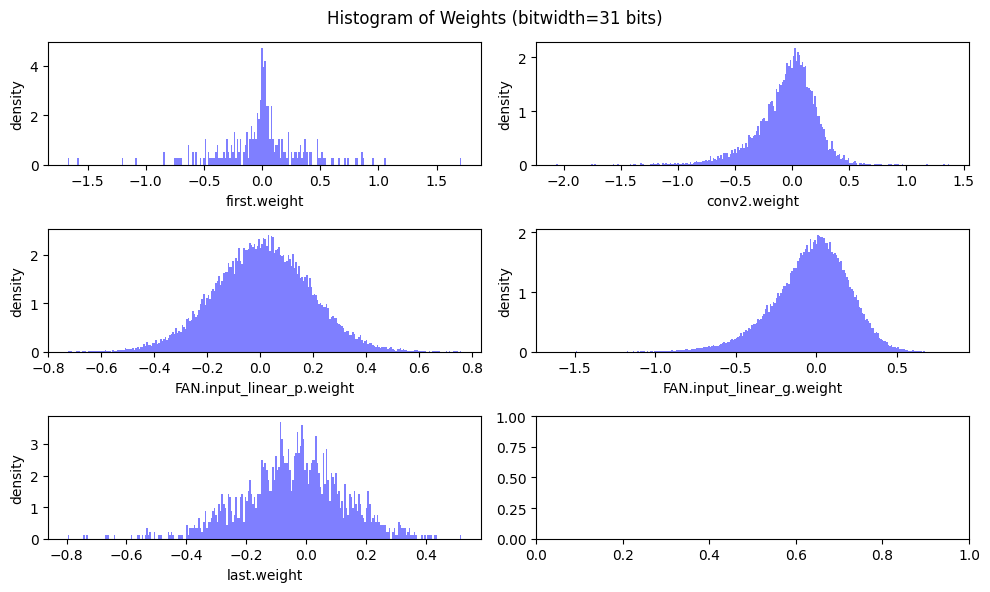

In [30]:
plot_weight_distribution(kd_model_last)

## PTQ

In [31]:
bitwidth = 2

In [32]:
def one_bit_quantization(model, bitwidth=8):
    """
    Quantizes the model parameters except for the specified layers.

    Args:
        model: The model to be quantized.
        bitwidth: The bit width for quantization (default is 8).
    
    Returns:
        tuple: (quantized_model, original_model)
    """
    # Create a copy of the original model
    quantized_model = copy.deepcopy(model)
    quantized_model_2 = copy.deepcopy(model)
    scales = {}
    
    # Calculate scale factors for each parameter
    for name, param in quantized_model.named_parameters():
        max_scale_factor = param.max()
        scales[name] = max_scale_factor

    # Apply quantization to all parameters except specified layers
    for name, param in quantized_model.named_parameters():
        if name not in ['first.weight', 'first.bias', 'last.weight', 'last.bias']:
            param.data = param.data.sign()  # Quantization step

    for name, param in quantized_model_2.named_parameters():
        if name not in ['first.weight', 'first.bias', 'last.weight', 'last.bias']:
            param.data = param.data.sign() * scales[name]  # Quantization step

    return quantized_model, quantized_model_2, model  # Return both quantized and original models

In [33]:
edge_last_model_one, edge_last_model_one_scale, model = one_bit_quantization(kd_model_last)

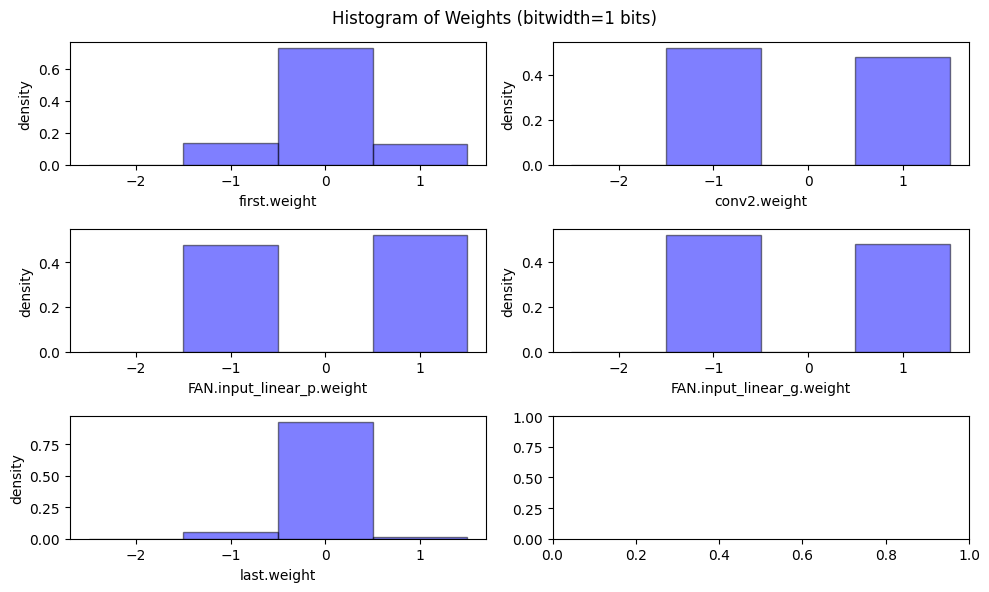

In [34]:
@torch.no_grad()

def peek_linear_quantization():
    for name, param in edge_last_model_one.named_parameters():
        if param.dim() > 1:
            quantized_param, scale, zero_point = \
                linear_quantize_weight_per_channel(param, bitwidth)
            param.copy_(quantized_param)
    plot_weight_distribution(edge_last_model_one, bitwidth)
        # recover_model()

peek_linear_quantization()

### PTQ Evaluation

In [35]:
test_loss, test_acc = test_loop(edge_last_model_one, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

Test accuracy 22.1198%


In [36]:
test_loss, test_acc = test_loop(edge_last_model_one_scale, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')

Test accuracy 28.5714%


In [37]:
# edge_last_model_one.FAN.input_linear_p.weight

# QAT

In [51]:
# from models.model import *

In [96]:
def binarize(tensor):
    return tensor.sign()

class BinarizeLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super(BinarizeLinear, self).__init__(in_features, out_features)

    def forward(self, input):
        # input * weight
        
        # binarize input
        input.data = binarize(input.data) # Binarize the tensor

        # binarize weight
        if not hasattr(self.weight, 'org'):
            self.weight.org = self.weight.data.clone()
            
        self.weight.data = binarize(self.weight.org)

        res = nn.functional.linear(input, self.weight)

        return res


class BinarizeConv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(BinarizeConv, self).__init__(in_channels, out_channels, kernel_size, stride,
                                           padding, dilation, groups, bias)

    def forward(self, input):
        # input * weight
        
        # binarize input
        input.data = binarize(input.data) # Binarize the tensor

        # binarize weight
        if not hasattr(self.weight, 'org'):
            self.weight.org = self.weight.data.clone()
            
        self.weight.data = binarize(self.weight.org)

        res = nn.functional.conv2d(input, self.weight)

        return res

In [110]:
class FANLayer(nn.Module):

    
    def __init__(self, input_dim, output_dim, p_ratio=0.25):
        super(FANLayer, self).__init__()
        
        # Ensure the p_ratio is within a valid range
        assert 0 < p_ratio < 0.5, "p_ratio must be between 0 and 0.5"
        
        self.p_ratio = p_ratio
        p_output_dim = int(output_dim * self.p_ratio)
        g_output_dim = output_dim - p_output_dim * 2  # Account for cosine and sine terms

        # Linear transformation for the p component (for cosine and sine parts)
        #self.input_linear_p = BinarizeLinear(input_dim, p_output_dim)
        self.input_linear_p = nn.Linear(input_dim, p_output_dim)
        
        # Linear transformation for the g component
        #self.input_linear_g = BinarizeLinear(input_dim, g_output_dim)
        self.input_linear_g = nn.Linear(input_dim, g_output_dim)

        #self.activation = nn.Hardtanh()
        self.activation = nn.GELU()
        

    def forward(self, src):
        """
        Args:
            src (Tensor): Input tensor of shape (batch_size, input_dim).
        
        Returns:
            Tensor: Output tensor of shape (batch_size, output_dim), after applying the FAN layer.
        """
        
        # Apply the linear transformation followed by the activation for the g component

        g = self.activation(self.input_linear_g(src))
        
        # Apply the linear transformation for the p component
        p = self.input_linear_p(src)

        # Concatenate cos(p), sin(p), and activated g along the last dimension
        output = torch.cat((torch.cos(p), torch.sin(p), g), dim=-1)

        
        return output

In [111]:
class EMGFANNew(nn.Module):
    def __init__(self, input_dim=1, output_dim=7, similarparameter=False):
        super(EMGFANNew, self).__init__()
        self.similarparameter = similarparameter
        self.out_gesture = output_dim
        self.in_channel = input_dim

        self.first = nn.Conv2d(self.in_channel, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        #self.htanh1 = nn.ReLU()
        self.htanh1 = nn.Hardtanh()
        #self.conv2 = nn.Conv2d(32, 32, kernel_size=3)

        self.conv2 = BinarizeConv(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        #self.htanh2 = nn.ReLU()
        self.htanh2 = nn.Hardtanh()

        # self.conv3 = nn.Conv2d(32, 32, kernel_size=1)
        # self.bn = nn.BatchNorm2d(32)
        # self.act = nn.ReLU()


        

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

        self.scalar = lambda x: x*4//3 if self.similarparameter else x
        self.FAN = FANLayer(576, self.scalar(256))
        self.bn3 = nn.BatchNorm1d(256)
        #self.htanh3 = nn.ReLU()
        self.htanh3 = nn.Hardtanh()

        self.last = nn.Linear(256, self.out_gesture)
    
    def forward(self, x):
        x = self.first(x)
        x = self.bn1(x)
        x = self.htanh1(x)


        x = self.conv2(x)
        x = self.bn2(x)
        x = self.htanh2(x)

        
        x = self.maxpool2(x)
        x = self.dropout(x)


        # x = self.conv3(x)
        # x = self.bn(x)
        # x = self.act(x)

        x = self.flatten(x)

        x = self.FAN(x)
        x = self.bn3(x)
        x = self.htanh3(x)

        x = self.last(x)
        return x

In [112]:
def QAT_fine_tune_loop(model, train_device, data, loss_fn, optimizer):

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    # print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")
    # print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e6} MB")

    # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')) as prof:
    #     with record_function("model_training"):

    for X, y in data:


            optimizer.zero_grad()

            X = X.float().to(train_device)
            y = y.long().to(train_device)
            model = model.to(train_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()

            for p in list(model.parameters()):
                if hasattr(p, 'org'):
                    p.data.copy_(p.org) # rest      


            optimizer.step()
            #scheduler.step()


            for p in list(model.parameters()):
                if hasattr(p, 'org'):
                    p.org.copy_(p.data.clamp_(-1, 1))
        


            train_loss += loss.item()
            total += y.size(0)
            correct += (y_pred.argmax(1) == y).sum().item()

    # print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6} MB")
    # print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1e6} MB")
    # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

    return train_loss / total, correct / total

In [113]:
model_one_bit_qat = EMGFANNew(1, number_gestures, similarparameter=False)
save_dir_meta = '/mnt/d/AI-Workspace/sEMGClassification/AdaptiveModel/code/models/model_weights/EMGFAN/KDMetaLearn/emgfankd_7_c.pth'
model_one_bit_qat .load_state_dict(torch.load(save_dir_meta))
model_one_bit_qat .to(device)
optimizer = optim.Adam(model_one_bit_qat.parameters(), lr=learning_rate)

In [114]:
model_one_bit_qat 

EMGFANNew(
  (first): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh1): Hardtanh(min_val=-1.0, max_val=1.0)
  (conv2): BinarizeConv(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh2): Hardtanh(min_val=-1.0, max_val=1.0)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FAN): FANLayer(
    (input_linear_p): Linear(in_features=576, out_features=64, bias=True)
    (input_linear_g): Linear(in_features=576, out_features=128, bias=True)
    (activation): GELU(approximate='none')
  )
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (htanh3): Hardtanh(min_val=-1.0, max_val=1.0)
  (last): Linear(in_features=256, out_features=

In [115]:
for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = QAT_fine_tune_loop(model_one_bit_qat, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)


end_time = time()
# tracker.stop()
AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')


print(f"KD Test on Last Layer Fine Tune {device}")
test_loss, test_acc = test_loop(model_one_bit_qat, device, test_dataloader, criterion)
print(f'Test accuracy {test_acc*100:.4f}%')
print(f'Training Time is {end_time - start_time}')

100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch 10/10
The Average FineTune Accuracy: 70.1300%
The Last FineTune Accuracy 79.1738%
KD Test on Last Layer Fine Tune cuda
Test accuracy 79.6083%
Training Time is 1533.4529011249542


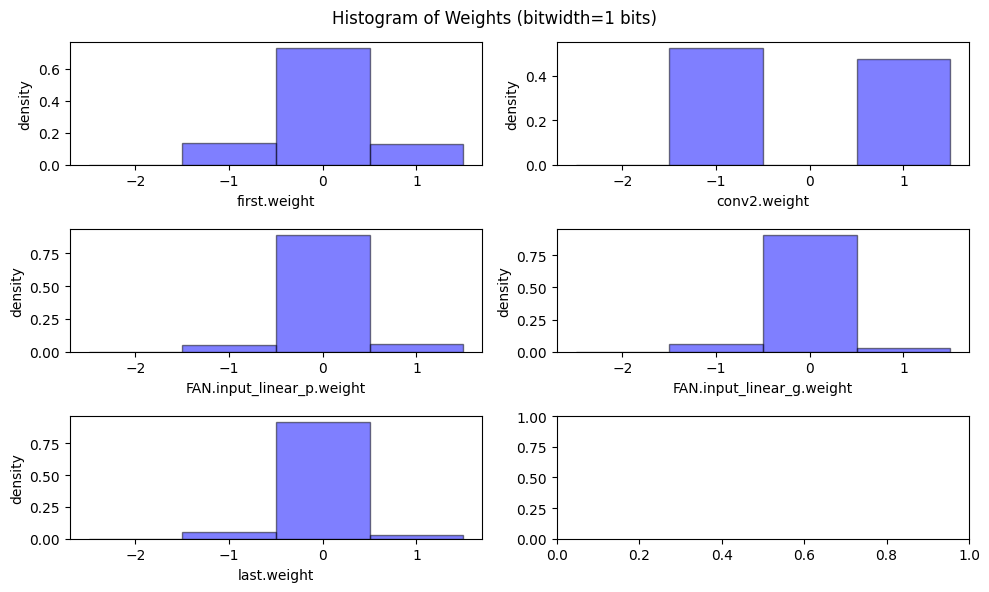

In [116]:
@torch.no_grad()

def peek_linear_quantization():
    for name, param in model_one_bit_qat.named_parameters():
        if param.dim() > 1:
            quantized_param, scale, zero_point = \
                linear_quantize_weight_per_channel(param, bitwidth)
            param.copy_(quantized_param)
    plot_weight_distribution(model_one_bit_qat, bitwidth)
        # recover_model()

peek_linear_quantization()

In [79]:
model_one_bit_qat.conv2.weight.unique()

tensor([-1.,  0.,  1.], device='cuda:0', grad_fn=<Unique2Backward0>)